[PySpark linear-regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)

# 1. Get pyspark lib

In [1]:
! pip install pyspark

     |████████████████████████████████| 215.7MB 48.7MB/s 
     |████████████████████████████████| 204kB 28.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216131250 sha256=5b882426239219ca03dfe8aae1d08c4430ca9e7989e0fcdc88815034882b16e6
  Stored in directory: /tmp/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [3]:
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, VectorIndexer, Bucketizer, OneHotEncoderEstimator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GeneralizedLinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
spark = SparkSession.builder.getOrCreate()
spark

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Load data

In [5]:
PATH = '/kaggle/input/house-prices-advanced-regression-techniques'
sdf_train = spark.read.csv(f'{PATH}/train.csv', inferSchema=True, header=True)
# 1460 rows × 81 columns

sdf_test = spark.read.csv(f'{PATH}/test.csv', inferSchema=True, header=True)
# 1459 rows × 80 columns

sdf_sample_submission = spark.read.csv(f'{PATH}/sample_submission.csv', 
                                       inferSchema=True, header=True)
col_sample_submission = ['Id','SalePrice']
# sdf_sample_submission.toPandas()

In [6]:
pdf = sdf_train.toPandas() # limit(5).
sdf_train.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

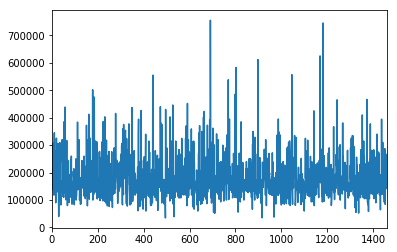

In [7]:
pdf['SalePrice'].plot.line()

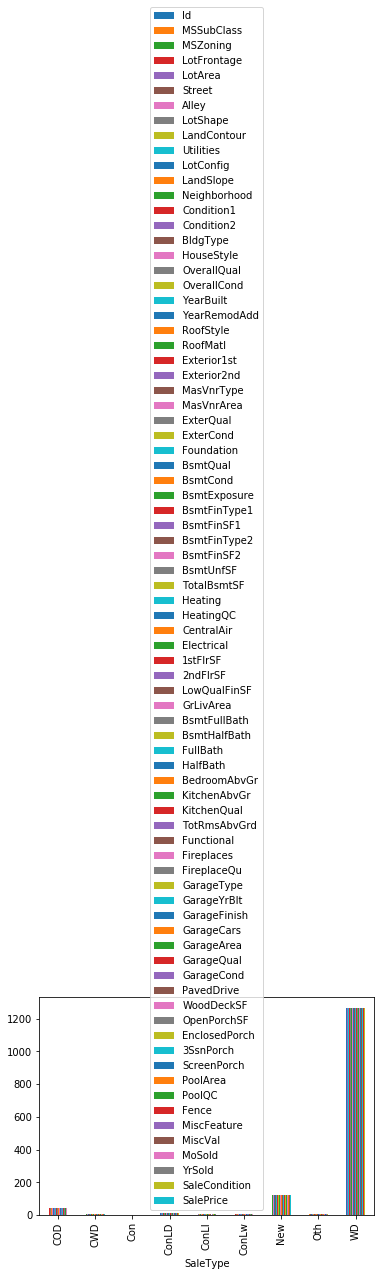

In [8]:
pdf.groupby('SaleType').count().plot.bar()

# 3. Feature selection

In [9]:
str_features = [] 
int_features = []
for col in  sdf_train.dtypes:
    if col[1] == 'string':
        str_features += [col[0]]
    else:
        int_features += [col[0]]
#     print(col)
print(f'str_features : {str_features}')
print(f'int_features: {int_features}')
# print(features)
sdf_train_filter = sdf_train.select(int_features + str_features)
int_features.remove('SalePrice')
sdf_test_filter = sdf_test.select(int_features + str_features)

str_features : ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
int_features: ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', '

In [10]:
# sdf_train.select(str_features).limit(5).toPandas().T

In [11]:
# sdf_test_filter.printSchema()
def _cast_to_int(_sdf: DataFrame,col_list: list) -> DataFrame:
    for col in col_list:
        _sdf = _sdf.withColumn(col, _sdf[col].cast('int'))
    return _sdf

sdf_test_typecast = _cast_to_int(sdf_test_filter, 
                                int_features)

In [12]:
# sdf_test.select([F.count(F.when(sdf_test[c] == 0 ,c )).alias(c) for c in int_features]).toPandas().T
# sdf_test_typecast.printSchema()

Ref:
https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1#Models


## String features


# 4. Model selection and Pipeline building

In [13]:
_stages = []
# Imputer not needed as no missing features
# null_impute = Imputer(inputCols= int_features, outputCols=int_features) 
# _stages += [null_impute]

str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
_stages += str_indexer

assembler_input = [f for f in int_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
_stages += [feature_vector]


vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
_stages += [vect_indexer]

LR = LinearRegression(featuresCol='features_indexed', 
                      labelCol= 'SalePrice',
                     maxIter=10,
                     regParam=0.3,
                     elasticNetParam=0.8)
_stages += [LR]

# DTR = DecisionTreeRegressor(featuresCol='features_indexed', labelCol= 'SalePrice') #0.223
# _stages += [DTR]

# GLR = GeneralizedLinearRegression(family='guissian',link= 'identity', maxIter=10, regParam=0.3)
# _stages += [GLR]
# IllegalArgumentException: 'GeneralizedLinearRegression_b8172476d09e parameter family given invalid value guissian.'

# RFR = RandomForestRegressor(featuresCol='features_indexed', labelCol='SalePrice') #0.18353
# _stages += [RFR]


# GBTR = GBTRegressor(featuresCol='features_indexed', labelCol='SalePrice', maxIter =10) #0.19474
# _stages += [GBTR]
# _stages

# 5. Start predicting, run Pipeline

In [14]:
ml_pipeline = Pipeline(stages=_stages)
model = ml_pipeline.fit(sdf_train_filter)


In [15]:
sdf_predict = model.transform(sdf_test_typecast)

In [16]:
sdf_predict.limit(5).toPandas().T

,0,1,2,3,4
Id,1461,1462,1463,1464,1465
MSSubClass,20,20,60,60,120
LotArea,11622,14267,13830,9978,5005
OverallQual,5,6,5,6,8
OverallCond,6,6,5,6,5
...,...,...,...,...,...
SaleType_StringIndexer,0,0,0,0,0
SaleCondition_StringIndexer,0,0,0,0,0
features,"(1461.0, 20.0, 11622.0, 5.0, 6.0, 1961.0, 1961...","(1462.0, 20.0, 14267.0, 6.0, 6.0, 1958.0, 1958...","(1463.0, 60.0, 13830.0, 5.0, 5.0, 1997.0, 1998...","(1464.0, 60.0, 9978.0, 6.0, 6.0, 1998.0, 1998....","(1465.0, 120.0, 5005.0, 8.0, 5.0, 1992.0, 1992..."
features_indexed,"(1461.0, 0.0, 11622.0, 4.0, 5.0, 1961.0, 1961....","(1462.0, 0.0, 14267.0, 5.0, 5.0, 1958.0, 1958....","(1463.0, 5.0, 13830.0, 4.0, 4.0, 1997.0, 1998....","(1464.0, 5.0, 9978.0, 5.0, 5.0, 1998.0, 1998.0...","(1465.0, 11.0, 5005.0, 7.0, 4.0, 1992.0, 1992...."


# 6. Prepare submission file

In [17]:

sdf_predict.withColumnRenamed('prediction','SalePrice')\
            .select('Id','SalePrice')\
            .coalesce(1)\
            .write.csv('submission',mode='overwrite',header=True)
print(os.listdir('submission'))

['.part-00000-f132ba0f-0590-416e-b429-fd6387d7f36d-c000.csv.crc', '_SUCCESS', '._SUCCESS.crc', 'part-00000-f132ba0f-0590-416e-b429-fd6387d7f36d-c000.csv']


<a href='submission/part-00000-c1528d69-7c6f-4916-b7a0-37f7c2e5a703-c000.csv'>submission</a>